##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# 用 tf.data 加载图片

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://tensorflow.google.cn/tutorials/load_data/images"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png" />在 tensorflow.google.cn 上查看</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/zh-cn/tutorials/load_data/images.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png" />在 Google Colab 运行</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/zh-cn/tutorials/load_data/images.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png" />在 Github 上查看源代码</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/zh-cn/tutorials/load_data/images.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png" />下载此 notebook</a>
  </td>
</table>

Note: 我们的 TensorFlow 社区翻译了这些文档。因为社区翻译是尽力而为， 所以无法保证它们是最准确的，并且反映了最新的
[官方英文文档](https://www.tensorflow.org/?hl=en)。如果您有改进此翻译的建议， 请提交 pull request 到
[tensorflow/docs](https://github.com/tensorflow/docs) GitHub 仓库。要志愿地撰写或者审核译文，请加入
[docs-zh-cn@tensorflow.org Google Group](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-zh-cn)。

本教程提供一个如何使用 `tf.data` 加载图片的简单例子。

本例中使用的数据集分布在图片文件夹中，一个文件夹含有一类图片。

## 配置

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

## 下载并检查数据集

### 检索图片

在你开始任何训练之前，你将需要一组图片来教会网络你想要训练的新类别。你已经创建了一个文件夹，存储了最初使用的拥有创作共用许可的花卉照片。

In [3]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

C:\Users\liucuili\.keras\datasets\flower_photos


下载了 218 MB 之后，你现在应该有花卉照片副本：

In [4]:
for item in data_root.iterdir():
  print(item)

C:\Users\liucuili\.keras\datasets\flower_photos\daisy
C:\Users\liucuili\.keras\datasets\flower_photos\dandelion
C:\Users\liucuili\.keras\datasets\flower_photos\LICENSE.txt
C:\Users\liucuili\.keras\datasets\flower_photos\roses
C:\Users\liucuili\.keras\datasets\flower_photos\sunflowers
C:\Users\liucuili\.keras\datasets\flower_photos\tulips


In [5]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [6]:
all_image_paths[:10]

['C:\\Users\\liucuili\\.keras\\datasets\\flower_photos\\daisy\\9175280426_40ecc395b8_m.jpg',
 'C:\\Users\\liucuili\\.keras\\datasets\\flower_photos\\sunflowers\\6140661443_bb48344226.jpg',
 'C:\\Users\\liucuili\\.keras\\datasets\\flower_photos\\tulips\\8677713853_1312f65e71.jpg',
 'C:\\Users\\liucuili\\.keras\\datasets\\flower_photos\\tulips\\16582481123_06e8e6b966_n.jpg',
 'C:\\Users\\liucuili\\.keras\\datasets\\flower_photos\\sunflowers\\10862313945_e8ed9202d9_m.jpg',
 'C:\\Users\\liucuili\\.keras\\datasets\\flower_photos\\sunflowers\\4831577091_f56157a5d5_n.jpg',
 'C:\\Users\\liucuili\\.keras\\datasets\\flower_photos\\roses\\5212885371_fe27c406a2_n.jpg',
 'C:\\Users\\liucuili\\.keras\\datasets\\flower_photos\\tulips\\8521597402_4b6169ba05.jpg',
 'C:\\Users\\liucuili\\.keras\\datasets\\flower_photos\\roses\\3751835302_d5a03f55e8_n.jpg',
 'C:\\Users\\liucuili\\.keras\\datasets\\flower_photos\\daisy\\23095658544_7226386954_n.jpg']

### 检查图片
现在让我们快速浏览几张图片，这样你知道你在处理什么：

In [7]:
import os
attributions = (data_root/"LICENSE.txt").open(encoding='utf-8').readlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)

In [8]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image (CC BY 2.0) " + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1])


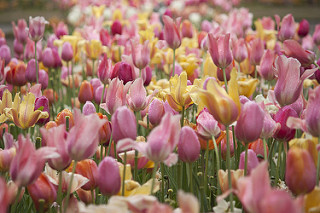

KeyError: 'tulips\\8748266132_5298a91dcf_n.jpg'

In [10]:
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print(caption_image(image_path))
  print()

### 确定每张图片的标签

列出可用的标签：

In [11]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

为每个标签分配索引：

In [12]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

创建一个列表，包含每个文件的标签索引：

In [13]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [0, 3, 4, 4, 3, 3, 2, 4, 2, 0]


### 加载和格式化图片

TensorFlow 包含加载和处理图片时你需要的所有工具：

In [14]:
img_path = all_image_paths[0]
img_path

'C:\\Users\\liucuili\\.keras\\datasets\\flower_photos\\daisy\\9175280426_40ecc395b8_m.jpg'

以下是原始数据：

In [15]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x...


将它解码为图像 tensor（张量）：

In [16]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(240, 240, 3)
<dtype: 'uint8'>


根据你的模型调整其大小：

In [17]:
img_final = tf.image.resize(img_tensor, [192, 192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())


(192, 192, 3)
0.0037990196
0.95980394


将这些包装在一个简单的函数里，以备后用。

In [18]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])
  image /= 255.0  # normalize to [0,1] range

  return image

In [19]:
def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

In [20]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(img_path))
plt.title(label_names[label].title())
print()

KeyError: 'daisy\\9175280426_40ecc395b8_m.jpg'

## 构建一个 `tf.data.Dataset`

### 一个图片数据集

构建 `tf.data.Dataset` 最简单的方法就是使用 `from_tensor_slices` 方法。

将字符串数组切片，得到一个字符串数据集：

In [21]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

`shapes（维数）` 和 `types（类型）` 描述数据集里每个数据项的内容。在这里是一组标量二进制字符串。

In [22]:
print(path_ds)

<TensorSliceDataset shapes: (), types: tf.string>


现在创建一个新的数据集，通过在路径数据集上映射 `preprocess_image` 来动态加载和格式化图片。

In [23]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

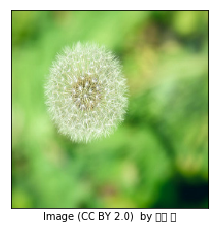

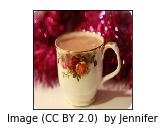

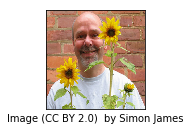

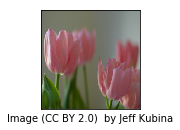

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(caption_image(all_image_paths[n]))
  plt.show()

### 一个`(图片, 标签)`对数据集

使用同样的 `from_tensor_slices` 方法你可以创建一个标签数据集：

In [25]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [26]:
for label in label_ds.take(10):
  print(label_names[label.numpy()])

dandelion
roses
sunflowers
tulips
roses
roses
roses
roses
roses
roses


由于这些数据集顺序相同，你可以将他们打包在一起得到一个`(图片, 标签)`对数据集：

In [27]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

这个新数据集的 `shapes（维数）` 和 `types（类型）` 也是维数和类型的元组，用来描述每个字段：

In [28]:
print(image_label_ds)

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


注意：当你拥有形似 `all_image_labels` 和 `all_image_paths` 的数组，`tf.data.dataset.Dataset.zip` 的替代方法是将这对数组切片。

In [29]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# 元组被解压缩到映射函数的位置参数中
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<MapDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

### 训练的基本方法

要使用此数据集训练模型，你将会想要数据：

* 被充分打乱。
* 被分割为 batch。
* 永远重复。
* 尽快提供 batch。

使用 `tf.data` api 可以轻松添加这些功能。

In [30]:
BATCH_SIZE = 32

# 设置一个和数据集大小一致的 shuffle buffer size（随机缓冲区大小）以保证数据
# 被充分打乱。
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# 当模型在训练的时候，`prefetch` 使数据集在后台取得 batch。
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

这里有一些注意事项：

1. 顺序很重要。

  * 在 `.repeat` 之后 `.shuffle`，会在 epoch 之间打乱数据（当有些数据出现两次的时候，其他数据还没有出现过）。
  
  * 在 `.batch` 之后 `.shuffle`，会打乱 batch 的顺序，但是不会在 batch 之间打乱数据。

1. 你在完全打乱中使用和数据集大小一样的 `buffer_size（缓冲区大小）`。较大的缓冲区大小提供更好的随机化，但使用更多的内存，直到超过数据集大小。

1. 在从随机缓冲区中拉取任何元素前，要先填满它。所以当你的 `Dataset（数据集）`启动的时候一个大的 `buffer_size（缓冲区大小）`可能会引起延迟。

1. 在随机缓冲区完全为空之前，被打乱的数据集不会报告数据集的结尾。`Dataset（数据集）`由 `.repeat` 重新启动，导致需要再次等待随机缓冲区被填满。


最后一点可以通过使用 `tf.data.Dataset.apply` 方法和融合过的 `tf.data.experimental.shuffle_and_repeat` 函数来解决:

In [31]:
ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

W0823 14:00:58.488550 140666875770624 deprecation.py:323] From <ipython-input-31-4dc713bd4d84>:2: shuffle_and_repeat (from tensorflow.python.data.experimental.ops.shuffle_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

### 传递数据集至模型

从 `tf.keras.applications` 取得 MobileNet v2 副本。

该模型副本会被用于一个简单的迁移学习例子。

设置 MobileNet 的权重为不可训练：

In [32]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

9412608/9406464 [==============================] - 2s 0us/step


该模型期望它的输出被标准化至 `[-1,1]` 范围内：

```
help(keras_applications.mobilenet_v2.preprocess_input)
```

<pre>
……
该函数使用“Inception”预处理，将
RGB 值从 [0, 255] 转化为 [-1, 1]
……
</pre>

在你将输出传递给 MobilNet 模型之前，你需要将其范围从 `[0,1]` 转化为 `[-1,1]`：

In [33]:
def change_range(image,label):
  return 2*image-1, label

keras_ds = ds.map(change_range)

MobileNet 为每张图片的特征返回一个 `6x6` 的空间网格。

传递一个 batch 的图片给它，查看结果：

In [34]:
# 数据集可能需要几秒来启动，因为要填满其随机缓冲区。
image_batch, label_batch = next(iter(keras_ds))

In [35]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 6, 6, 1280)


构建一个包装了 MobileNet 的模型并在 `tf.keras.layers.Dense` 输出层之前使用 `tf.keras.layers.GlobalAveragePooling2D` 来平均那些空间向量：

In [36]:
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names), activation = 'softmax')])

现在它产出符合预期 shape(维数)的输出：

In [37]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: 0.004745514
max logit: 0.738402

Shape: (32, 5)


编译模型以描述训练过程：

In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

此处有两个可训练的变量 —— Dense 层中的 `weights（权重）` 和 `bias（偏差）`：

In [39]:
len(model.trainable_variables)

2

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


你已经准备好来训练模型了。

注意，出于演示目的每一个 epoch 中你将只运行 3 step，但一般来说在传递给 `model.fit()` 之前你会指定 step 的真实数量，如下所示：

In [41]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

115.0

In [42]:
model.fit(ds, epochs=1, steps_per_epoch=3)

W0823 14:01:29.522912 140666875770624 deprecation.py:323] From /tmpfs/src/tf_docs_env/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


3/3 [==============================] - 11s 4s/step - loss: 2.1655 - accuracy: 0.1250


## 性能

注意：这部分只是展示一些可能帮助提升性能的简单技巧。深入指南，请看：[输入 pipeline（管道）的性能](https://tensorflow.google.cn/guide/performance/datasets)。

上面使用的简单 pipeline（管道）在每个 epoch 中单独读取每个文件。在本地使用 CPU 训练时这个方法是可行的，但是可能不足以进行 GPU 训练并且完全不适合任何形式的分布式训练。

要研究这点，首先构建一个简单的函数来检查数据集的性能：

In [43]:
import time
default_timeit_steps = 2*steps_per_epoch+1

def timeit(ds, steps=default_timeit_steps):
  overall_start = time.time()
  # 在开始计时之前
  # 取得单个 batch 来填充 pipeline（管道）（填充随机缓冲区）
  it = iter(ds.take(steps+1))
  next(it)

  start = time.time()
  for i,(images,labels) in enumerate(it):
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))
  print("Total time: {}s".format(end-overall_start))

当前数据集的性能是：

In [44]:
ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [45]:
timeit(ds)

........................
231.0 batches: 16.92088532447815 s
436.85657 Images/s
Total time: 25.368468761444092s


### 缓存

使用 `tf.data.Dataset.cache` 在 epoch 之间轻松缓存计算结果。这是非常高效的，特别是当内存能容纳全部数据时。

在被预处理之后（解码和调整大小），图片在此被缓存了：

In [46]:
ds = image_label_ds.cache()
ds = ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [47]:
timeit(ds)

........................
231.0 batches: 1.134613275527954 s
6514.99516 Images/s
Total time: 9.517362356185913s


使用内存缓存的一个缺点是必须在每次运行时重建缓存，这使得每次启动数据集时有相同的启动延迟：

In [48]:
timeit(ds)

........................
231.0 batches: 1.2321326732635498 s
5999.35393 Images/s
Total time: 9.307711839675903s


如果内存不够容纳数据，使用一个缓存文件：

In [49]:
ds = image_label_ds.cache(filename='./cache.tf-data')
ds = ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(1)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [50]:
timeit(ds)

........................
231.0 batches: 4.042354583740234 s
1828.63721 Images/s
Total time: 14.688445091247559s


这个缓存文件也有可快速重启数据集而无需重建缓存的优点。注意第二次快了多少：

In [51]:
timeit(ds)

........................
231.0 batches: 3.2597713470458984 s
2267.64371 Images/s
Total time: 5.137566566467285s


### TFRecord 文件

#### 原始图片数据

TFRecord 文件是一种用来存储一串二进制 blob 的简单格式。通过将多个示例打包进同一个文件内，TensorFlow 能够一次性读取多个示例，当使用一个远程存储服务，如 GCS 时，这对性能来说尤其重要。

首先，从原始图片数据中构建出一个 TFRecord 文件：

In [52]:
image_ds = tf.data.Dataset.from_tensor_slices(all_image_paths).map(tf.io.read_file)
tfrec = tf.data.experimental.TFRecordWriter('images.tfrec')
tfrec.write(image_ds)

接着，构建一个从 TFRecord 文件读取的数据集，并使用你之前定义的 `preprocess_image` 函数对图像进行解码/重新格式化：

In [53]:
image_ds = tf.data.TFRecordDataset('images.tfrec').map(preprocess_image)

压缩该数据集和你之前定义的标签数据集以得到期望的 `(图片,标签)` 对：

In [54]:
ds = tf.data.Dataset.zip((image_ds, label_ds))
ds = ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds=ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int64)>

In [55]:
timeit(ds)

........................
231.0 batches: 16.205776691436768 s
456.13365 Images/s
Total time: 24.12787389755249s


这比 `缓存` 版本慢，因为你还没有缓存预处理。

#### 序列化的 Tensor（张量）

要为 TFRecord 文件省去一些预处理过程，首先像之前一样制作一个处理过的图片数据集：

In [56]:
paths_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = paths_ds.map(load_and_preprocess_image)
image_ds

<MapDataset shapes: (192, 192, 3), types: tf.float32>

现在你有一个 tensor（张量）数据集，而不是一个 `.jpeg` 字符串数据集。

要将此序列化至一个 TFRecord 文件你首先将该 tensor（张量）数据集转化为一个字符串数据集：

In [57]:
ds = image_ds.map(tf.io.serialize_tensor)
ds

<MapDataset shapes: (), types: tf.string>

In [58]:
tfrec = tf.data.experimental.TFRecordWriter('images.tfrec')
tfrec.write(ds)

有了被缓存的预处理，就能从 TFrecord 文件高效地加载数据——只需记得在使用它之前反序列化：

In [59]:
ds = tf.data.TFRecordDataset('images.tfrec')

def parse(x):
  result = tf.io.parse_tensor(x, out_type=tf.float32)
  result = tf.reshape(result, [192, 192, 3])
  return result

ds = ds.map(parse, num_parallel_calls=AUTOTUNE)
ds

<ParallelMapDataset shapes: (192, 192, 3), types: tf.float32>

现在，像之前一样添加标签和进行相同的标准操作：

In [60]:
ds = tf.data.Dataset.zip((ds, label_ds))
ds = ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds=ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int64)>

In [61]:
timeit(ds)

........................
231.0 batches: 2.740431070327759 s
2697.38585 Images/s
Total time: 6.3629655838012695s
